In [1]:
# Visual ROIs (total 9)
visual_rois = ["Left Lateral Occipital Complex", "Right Lateral Occipital Complex", "Left Fusiform Face Area", "Right Fusiform Face Area", "Left Parahippocampal Place Area",
               "Right Parahippocampal Place Area", "Left Extrastriate Body Area", "Right Extrastriate Body Area", "Inferotemporal Cortex"]

# Memory ROIs (total 19)
memory_rois = ["Parahippocampal Area 1", "Parahippocampal Area 2", "Parahippocampal Area 3", "Entorhinal Cortex", "Presubiculum", "Hippocampus", "Prosubiculum",
               "Perirhinal Cortex", "Retrosplenial Cortex", "Left Retrosplenial Cortex", "Right Retrosplenial Cortex", "Subgenual Cortex",
               "Superior Anterior Cingulate Cortex", "Posterior Orbitofrontal Cortex", "Right Anterior Prefrontal Cortex", "Ventral Anterior Prefrontal Cortex",
               "Medial Prefrontal Cortex", "Dorsolateral Prefrontal Cortex", "Dorsomedial Prefrontal Cortex"]

## 1) Load data (voxel responses & voxels ROI mapping)
- **Data cleaning**: Remove samples with missing values in either *memorability score* or *category label*.
- **Merge dataframes**: Combine memorability scores with voxel response data into a single dataframe.

In [2]:
from google.colab import drive
import os, h5py
import pandas as pd

def load_data(subject_id, folder_path="/content/drive/My Drive/ML_project"):

    # Mount only once if needed
    drive.mount('/content/drive', force_remount=True)

    # Paths
    filename1 = f"{subject_id}_VoxelResponses.h5"
    filename2 = f"{subject_id}_Voxel_ROI_Mapping.csv"

    os.chdir(folder_path)
    !cp $filename1 /content/
    !cp $filename2 /content/
    os.chdir('/content')

    # Load HDF5 voxel response data
    with h5py.File(filename1, "r") as h5f:
        stimulus_names = h5f["stimulus_names"][:].astype(str)
        concepts = h5f["concepts"][:].astype(str)
        memorability_scores = h5f["memorability_scores"][:]
        category_labels = h5f["category_labels"][:].astype(str)
        voxel_responses = h5f["voxel_responses"][:]  # (samples, voxels)
        voxel_ids_all = h5f["voxel_ids"][:].astype(int)

    # Construct metadata DataFrame
    df = pd.DataFrame({
        "stimulus_name": stimulus_names,
        "concept": concepts,
        "memorability_score": memorability_scores,
        "category_label": category_labels
    })
    print("Shape before cleaning:", df.shape)

    # Data cleaning: remove rows with missing or invalid values
    valid_mask = (
        df["memorability_score"].notna() &
        df["category_label"].notna() &
        (df["category_label"].str.lower() != "nan")
    )
    df_filtered = df[valid_mask].copy()
    voxel_responses_filtered = voxel_responses[valid_mask.values, :]
    print("Filtered rows:", df_filtered.shape[0])

    # Create column names for voxels
    voxel_columns = [f"voxel_{vid}" for vid in voxel_ids_all]

    # Combine metadata and voxel responses
    data = pd.concat([
        df_filtered[["stimulus_name", "concept", "category_label", "memorability_score"]].reset_index(drop=True),
        pd.DataFrame(voxel_responses_filtered, columns=voxel_columns)
    ], axis=1)

    # Load ROI mapping file
    roi_df = pd.read_csv(filename2)
    roi_df['ROIs'] = roi_df['ROIs'].apply(lambda x: [r.strip() for r in x.split(',')])
    roi_df['Voxel ID'] = roi_df['Voxel ID'].astype(int)

    # Return cleaned and merged data
    return data, roi_df

## 2) Preprocessing
- **Feature selection**: Select voxel features from:
  - All **visual ROIs**, or
  - All **memory ROIs**, or
  - A specific **visual**/**memory ROI**.
- **Binary label creation**: Add a `memorability_class` column (0 = low, 1 = high) using a median split.
- **Dataset balancing** (two options):
  - **Bin-based**: Bin memorability scores into 10 equal-width intervals (0–1), then downsample each bin to the size of the smallest valid bin.
  - **Class-based**: Downsample the dataset so that both binary classes (0/1) have equal representation.


In [3]:
def prepare_data(data, roi_df, selected_rois, balance_method, min_samples_per_bin=50, random_state=42):
    """
    Prepares the dataset by filtering for selected ROIs, creating binary labels,
    and balancing the data either by bin or class.

    Parameters:
        data (pd.DataFrame): Merged DataFrame with voxel data and metadata.
        roi_df (pd.DataFrame): ROI mapping DataFrame.
        selected_rois (list): List of ROI names to select.
        balance_method (str): 'bin' or 'class' – how to balance the dataset.
        min_samples_per_bin (int): Minimum bin size if using bin balancing.
        random_state (int): For reproducibility.

    Returns:
        balanced_df (pd.DataFrame): Balanced dataset ready for model input.
    """

    # --- Step 1: Filter for selected ROIs ---
    roi_filtered = roi_df[roi_df['ROIs'].apply(lambda roi_list: any(roi in selected_rois for roi in roi_list))]
    voxel_ids = roi_filtered['Voxel ID'].astype(str)

    non_voxel_cols = ['stimulus_name', 'concept', 'category_label', 'memorability_score']
    cols_to_keep = non_voxel_cols + [f'voxel_{vid}' for vid in voxel_ids]

    filtered_data = data[cols_to_keep].copy()
    print(f"Selected {len(voxel_ids)} voxels from ROI(s): {selected_rois}")
    print("Filtered Data shape:", filtered_data.shape)
    #display(filtered_data)

    # --- Step 2: Create binary classification label ---
    threshold = filtered_data['memorability_score'].median()
    filtered_data['memorability_class'] = (filtered_data['memorability_score'] > threshold).astype(int)
    print(f"Binary label threshold (median): {threshold}")

    # --- Step 3: Balance dataset ---
    balanced_df = balance_dataset(filtered_data, balance_method, min_samples_per_bin, random_state)

    return balanced_df


def balance_dataset(df, balance_method, min_samples_per_bin=50, random_state=42):
    """
    Balance the dataset using either bin-based downsampling or class-based downsampling.
    method (str): 'bin' or 'class'
    Returns the balanced dataset
    """
    df = df.copy()

    if balance_method == 'bin':
        # 1. Bin memorability scores
        bins = [i/10 for i in range(11)]
        labels = [f"{bins[i]}–{bins[i+1]}" for i in range(10)]
        df['mem_bin'] = pd.cut(df['memorability_score'], bins=bins, labels=labels, include_lowest=True)

        # 2. Check non-empty bins
        bin_counts = df['mem_bin'].value_counts().sort_index()
        non_empty_bins = bin_counts[bin_counts >= min_samples_per_bin]
        print("Bin sizes:\n", bin_counts)

        if non_empty_bins.empty:
            print("No bins meet the minimum sample requirement.")
            return None

        min_bin_size = non_empty_bins.min()
        print(f"\nSmallest non-empty bin has {min_bin_size} samples.")

        # 3. Filter and balance
        df = df[df['mem_bin'].isin(non_empty_bins.index)]
        balanced_df = (
            df.groupby('mem_bin', group_keys=False, observed=True)
            .apply(lambda x: x.sample(n=min(len(x), min_bin_size), random_state=random_state))
            .reset_index(drop=True)
        )

        print("\nBalanced bin sizes:\n", balanced_df['mem_bin'].value_counts().sort_index())

    elif balance_method == 'class':
        # Check class distribution
        class_counts = df['memorability_class'].value_counts()
        print("Class counts:\n", class_counts)

        min_class_size = class_counts.min()
        print(f"\nSmallest class has {min_class_size} samples.")

        # Downsample
        balanced_df = (
            df.groupby('memorability_class', group_keys=False)
            .apply(lambda x: x.sample(n=min_class_size, random_state=random_state))
            .reset_index(drop=True)
        )

        print("\nBalanced class distribution:\n", balanced_df['memorability_class'].value_counts())

    else:
        raise ValueError("Method must be either 'bin' or 'class'.")

    print('\nBalanced Data:')
    display(balanced_df)

    return balanced_df

## 3) SVC (Support Vector Classifier) model

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_score, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def run_svc(X_train_balanced, y_train_balanced, X_test_scaled, y_test, subject_id, roi_label, method):
  if method == 'class':
    # Apply PCA first
    pca = PCA(n_components=100, random_state=42)
    X_train_pca = pca.fit_transform(X_train_balanced)
    X_test_pca = pca.transform(X_test_scaled)

    # Then use SVC with a smaller grid
    clf = SVC(kernel='rbf', C=10, gamma=0.1)
    clf.fit(X_train_pca, y_train_balanced)

  elif method == 'bin':
    # Grid Search for best hyperparameters
    param_grid = {
        'C': [1, 10, 100],
        'gamma': [0.1, 0.5, 1],
        'kernel': ['rbf']
    }
    grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5, scoring='accuracy', verbose=3, n_jobs=-1)
    grid_search.fit(X_train_balanced, y_train_balanced)
    clf = grid_search.best_estimator_
    print(f"Best SVC parameters: {grid_search.best_params_}")

  # Predict and evaluate
  if method == 'class':
    predicted_y = clf.predict(X_test_pca)
    y_scores = clf.decision_function(X_test_pca)

  else:
    predicted_y = clf.predict(X_test_scaled)
    y_scores = clf.decision_function(X_test_scaled)


  results = {
      "precision": precision_score(y_test, predicted_y, zero_division=1),
      "accuracy": accuracy_score(y_test, predicted_y),
      "f1_score": f1_score(y_test, predicted_y),
      "roc_auc": roc_auc_score(y_test, predicted_y),
      "predicted_distribution": np.bincount(predicted_y).tolist()
  }
  # Print results
  print("\nSVC Evaluation Results:")
  print("Accuracy Score:", round(results["accuracy"], 2))
  print("Precision Score:", round(results["precision"], 2))
  print("F1 Score:", round(results["f1_score"], 2))
  print("ROC AUC:", round(results["roc_auc"], 2))
  print("Predicted Class Distribution:", results["predicted_distribution"])

  # Plot Confusion Matrix
  cm = confusion_matrix(y_test, predicted_y)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['High', 'Low'])
  disp.plot(cmap='Blues')
  plt.title(f"SVC Confusion Matrix - {subject_id or ''} | {roi_label or ''}")
  plt.grid(False)
  plt.show()

  # ROC Curve
  fpr, tpr, _ = roc_curve(y_test, y_scores)
  plt.figure(figsize=(6, 5))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {results['roc_auc']:.2f}")
  plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(f"SVC ROC Curve - {subject_id or ''} | {roi_label or ''}")
  plt.legend(loc="lower right")
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  return results

## 4) MLP (Multi Layer Perceptron) Model

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, accuracy_score, f1_score, roc_auc_score, roc_curve, auc, log_loss
import matplotlib.pyplot as plt

def run_mlp(X_train_balanced, y_train_balanced, X_test_scaled, y_test, subject_id, roi_label):
  # 1. Initialize the model
  mlp = MLPClassifier(
      hidden_layer_sizes=(128, 64),
      activation='relu',
      solver='adam',
      alpha=0.001,
      learning_rate_init=0.001,
      max_iter=500,
      early_stopping=True,
      random_state=42
  )
  # 2. Train the model
  mlp.fit(X_train_balanced, y_train_balanced)

  # 3. Predictions and Probabilities
  mlp_preds = mlp.predict(X_test_scaled)
  mlp_proba = mlp.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1

  # 4. Evaluate
  results = {
      "precision": precision_score(y_test, mlp_preds, zero_division=1),
      "accuracy": accuracy_score(y_test, mlp_preds),
      "f1_score": f1_score(y_test, mlp_preds),
      "roc_auc": roc_auc_score(y_test, mlp_proba),
      "train_loss": mlp.loss_curve_[-1] if hasattr(mlp, "loss_curve_") else None,
      "test_loss": log_loss(y_test, mlp_proba),
      "train_acc": mlp.score(X_train_balanced, y_train_balanced),
      "predicted_distribution": np.bincount(mlp_preds).tolist()
  }

  # 5. Print evaluation
  print("\nMLP Evaluation Results:")
  print("Train Accuracy Score:", round(results['train_acc'], 2))
  print("(Test) Accuracy Score:", round(results["accuracy"], 2))
  print("Precision Score:", round(results["precision"], 2))
  print("F1 Score:", round(results["f1_score"], 2))
  print("Predicted Class Distribution:", results["predicted_distribution"])

  # 6. Plot ROC Curve
  fpr, tpr, _ = roc_curve(y_test, mlp_proba)
  roc_auc = auc(fpr, tpr)
  plt.figure(figsize=(6, 5))
  plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
  plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(f"MLP ROC Curve - {subject_id or ''} | {roi_label or ''}")
  plt.legend(loc="lower right")
  plt.grid(True)
  plt.tight_layout()
  plt.show()


  # 7. Plot Training + Test Loss
  plt.figure(figsize=(10, 5))
  plt.plot(mlp.loss_curve_, label='Training Loss', color='green')

  # Plot test loss as a horizontal line
  test_loss = results["test_loss"]
  plt.axhline(y=test_loss, color='blue', linestyle='--', label=f"Test Loss = {results['test_loss']:.2f}")

  plt.title(f"MLP Training and Test Loss - {subject_id or ''} | {roi_label or ''}")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  return results

## 5) Attempts to improve MLP model (adding layers, changing hyperparameters etc.)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
# for train_index, test_index in sss.split(X, y):
#     X_train = X.iloc[train_index]
#     X_test = X.iloc[test_index]
#     y_train = y[train_index]
#     y_test = y[test_index]

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).unsqueeze(1)
# y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).unsqueeze(1)

# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

# class MemorabilityMLP(nn.Module):
#     def __init__(self, input_dim):
#         super(MemorabilityMLP, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, 16), ### WE COULD EVEN REDUCE MORE AND START WITH 8 NEURONS##
#             nn.BatchNorm1d(16),
#             nn.ReLU(),
#             nn.Dropout(0.4),

#             nn.Linear(16, 8),
#             nn.BatchNorm1d(8),
#             nn.ReLU(),
#             nn.Dropout(0.2),

#             nn.Linear(8, 4),
#             nn.BatchNorm1d(4),
#             nn.ReLU(),
#             nn.Linear(4, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         return self.model(x)

# input_dim = X_train_scaled.shape[1]
# model = MemorabilityMLP(input_dim)

# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0002)

# num_epochs = 40
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# train_losses = []
# test_losses = []
# test_accuracies = []

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     batch_count = 0

#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         optimizer.zero_grad()
#         outputs = model(X_batch)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         batch_count += 1

#     train_loss = running_loss / batch_count
#     train_losses.append(train_loss)

#     model.eval()
#     test_loss = 0.0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for X_t, y_t in test_loader:
#             X_t, y_t = X_t.to(device), y_t.to(device)
#             outputs_t = model(X_t)
#             loss_t = criterion(outputs_t, y_t)
#             test_loss += loss_t.item()
#             predicted = (outputs_t >= 0.5).float()
#             correct += (predicted == y_t).sum().item()
#             total += y_t.size(0)

#     test_loss /= len(test_loader)
#     test_losses.append(test_loss)
#     accuracy = correct / total
#     test_accuracies.append(accuracy)

#     if epoch % 5 == 0:
#         print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

# plt.figure(figsize=(12, 6))
# plt.plot(train_losses, label='Training Loss', color='green')
# plt.plot(test_losses, label='Validation Loss', color='lightblue')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# plt.figure(figsize=(12, 6))
# plt.plot(test_accuracies, label='Validation Accuracy')
# plt.title('Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# # **Final Evaluation**
# model.eval()
# final_predictions = []
# final_targets = []
# with torch.no_grad():
#     for X_t, y_t in test_loader:
#         X_t, y_t = X_t.to(device), y_t.to(device)
#         outputs_t = model(X_t)
#         predicted_classes = (outputs_t >= 0.5).float()  # Convert probabilities to binary outputs
#         final_predictions.extend(predicted_classes.cpu().numpy())
#         final_targets.extend(y_t.cpu().numpy())

# # Convert lists to numpy arrays for metric calculations
# final_predictions = np.array(final_predictions).flatten()
# final_targets = np.array(final_targets).flatten()

# # Calculate precision, accuracy, and F1 score
# final_precision = precision_score(final_targets, final_predictions, zero_division=1)
# final_accuracy = accuracy_score(final_targets, final_predictions)
# final_f1_score = f1_score(final_targets, final_predictions)

# print(f"\nFinal Precision: {final_precision:.4f}")
# print(f"Final Accuracy: {final_accuracy:.4f}")
# print(f"Final F1 Score: {final_f1_score:.4f}")

# Main Loop

In [6]:
ROI_GROUPS = {
    "Memory ROIs": memory_rois,
    "Visual ROIs": visual_rois,
    "Right FFA": ['Right Fusiform Face Area'],
    "Left PPA": ['Left Parahippocampal Place Area']
}


# Parameters
SUBJECT_ID = "sub-01"
# SUBJECT_ID = "sub-02"
# SUBJECT_ID = "sub-03"

BALANCE_METHOD = 'bin'
#BALANCE_METHOD = 'class'

Mounted at /content/drive
Shape before cleaning: (8740, 4)
Filtered rows: 6517


-------Running model for ROI: Memory ROIs-------


Selected 7598 voxels from ROI(s): ['Parahippocampal Area 1', 'Parahippocampal Area 2', 'Parahippocampal Area 3', 'Entorhinal Cortex', 'Presubiculum', 'Hippocampus', 'Prosubiculum', 'Perirhinal Cortex', 'Retrosplenial Cortex', 'Left Retrosplenial Cortex', 'Right Retrosplenial Cortex', 'Subgenual Cortex', 'Superior Anterior Cingulate Cortex', 'Posterior Orbitofrontal Cortex', 'Right Anterior Prefrontal Cortex', 'Ventral Anterior Prefrontal Cortex', 'Medial Prefrontal Cortex', 'Dorsolateral Prefrontal Cortex', 'Dorsomedial Prefrontal Cortex']
Filtered Data shape: (6517, 7602)
Binary label threshold (median): 0.800000011920929
Bin sizes:
 mem_bin
0.0–0.1       0
0.1–0.2       0
0.2–0.3       0
0.3–0.4       0
0.4–0.5       8
0.5–0.6      73
0.6–0.7     696
0.7–0.8    2341
0.8–0.9    2935
0.9–1.0     464
Name: count, dtype: int64

Smallest non-empty bin has 73 

<ipython-input-3-ed5002609ad6>:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), min_bin_size), random_state=random_state))


,stimulus_name,concept,category_label,memorability_score,voxel_26218,voxel_26288,voxel_26319,voxel_26345,voxel_26346,voxel_26369,...,voxel_190889,voxel_190890,voxel_190891,voxel_190914,voxel_190915,voxel_190916,voxel_190939,voxel_190961,memorability_class,mem_bin
0,ant_10s.jpg,ant,animal,0.595238,0.101097,0.006289,-0.012635,-0.041537,-0.035150,0.002682,...,0.063364,-0.023803,-0.016329,-0.055460,-0.078122,-0.096779,0.004969,0.147538,0,0.5–0.6
1,tomato_10n.jpg,tomato,food,0.564103,0.027230,0.040056,0.033413,0.072592,0.032469,0.100794,...,0.022845,0.003260,-0.019552,0.032815,0.009206,0.030225,-0.065298,0.018859,0,0.5–0.6
2,cheese_01b.jpg,cheese,dessert,0.575000,0.073897,-0.003664,0.066516,0.058161,-0.020089,-0.033983,...,-0.029346,0.008204,0.021597,-0.039811,-0.084688,-0.060473,0.058403,0.016877,0,0.5–0.6
3,airbag_07s.jpg,airbag,part of car,0.578947,-0.076573,-0.028203,-0.081692,0.023658,-0.032682,-0.001837,...,-0.040243,-0.046979,0.053540,-0.040824,-0.004760,0.024638,-0.080185,0.012663,0,0.5–0.6
4,defibrillator_01b.jpg,defibrillator,electronic device,0.550000,0.013564,0.096741,0.116170,0.100827,0.074896,-0.049311,...,-0.134189,0.053798,0.057081,-0.026057,-0.059945,0.067855,-0.012587,-0.128734,0,0.5–0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,banana_04s.jpg,banana,food,0.925000,0.007288,-0.029733,0.049790,0.056994,-0.032158,-0.024793,...,0.090121,-0.003864,0.024885,-0.008750,0.030802,-0.003582,-0.045194,0.035470,1,0.9–1.0
361,overalls_05s.jpg,overalls,clothing,0.904762,-0.137284,-0.091349,-0.063827,-0.009832,-0.002337,-0.016623,...,0.000626,0.017964,0.028698,-0.046313,-0.059874,0.005234,-0.052701,0.009229,1,0.9–1.0
362,peach_11n.jpg,peach,food,0.906977,-0.043706,-0.051188,-0.070010,-0.063706,-0.049333,0.094850,...,0.037957,0.108416,-0.054708,-0.006981,-0.010535,0.048673,0.037408,-0.050546,1,0.9–1.0
363,brownie_06s.jpg,brownie,dessert,0.921053,-0.032631,0.019328,0.018780,-0.022360,-0.099345,-0.040916,...,-0.000495,0.120234,0.004167,-0.039714,-0.087873,-0.075928,-0.043924,0.058148,1,0.9–1.0


Original Class Distribution in Train Set: [182 110]
Balanced Class Distribution in Train Set: [110 110]
Training set bin distribution:
mem_bin
0.0–0.1     0
0.1–0.2     0
0.2–0.3     0
0.3–0.4     0
0.4–0.5     0
0.5–0.6    55
0.6–0.7    57
0.7–0.8    64
0.8–0.9    61
0.9–1.0    55
Name: count, dtype: int64
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best SVC parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

SVC Evaluation Results:
Accuracy Score: 0.48
Precision Score: 0.43
F1 Score: 0.58
ROC AUC: 0.54
Predicted Class Distribution: [13, 60]


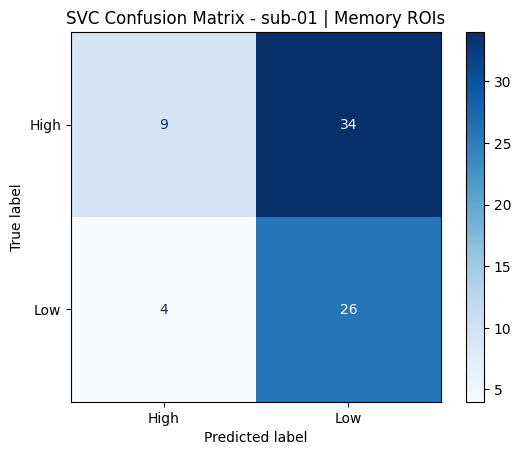

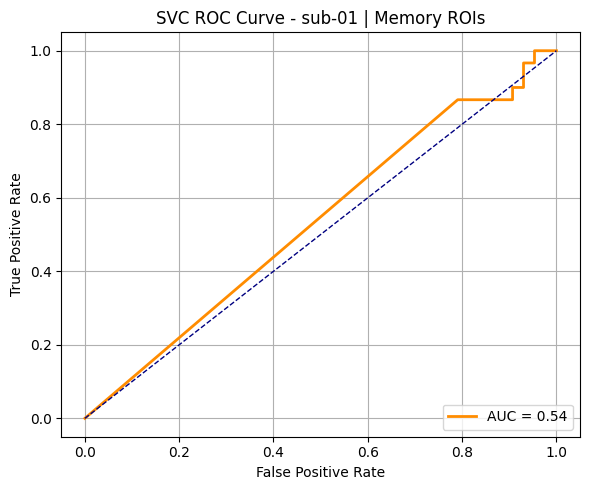


MLP Evaluation Results:
Train Accuracy Score: 0.97
(Test) Accuracy Score: 0.64
Precision Score: 0.56
F1 Score: 0.61
Predicted Class Distribution: [37, 36]


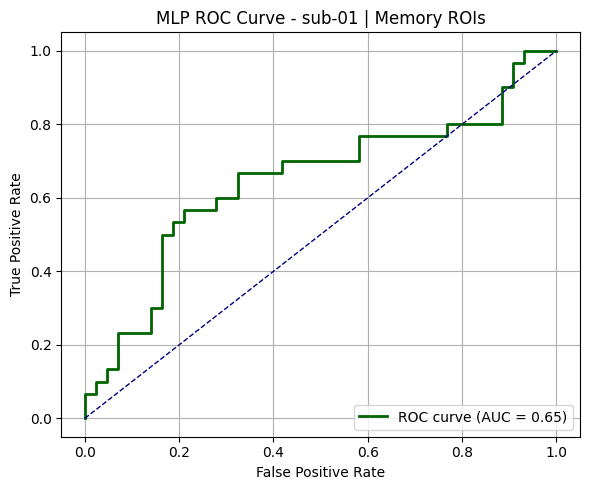

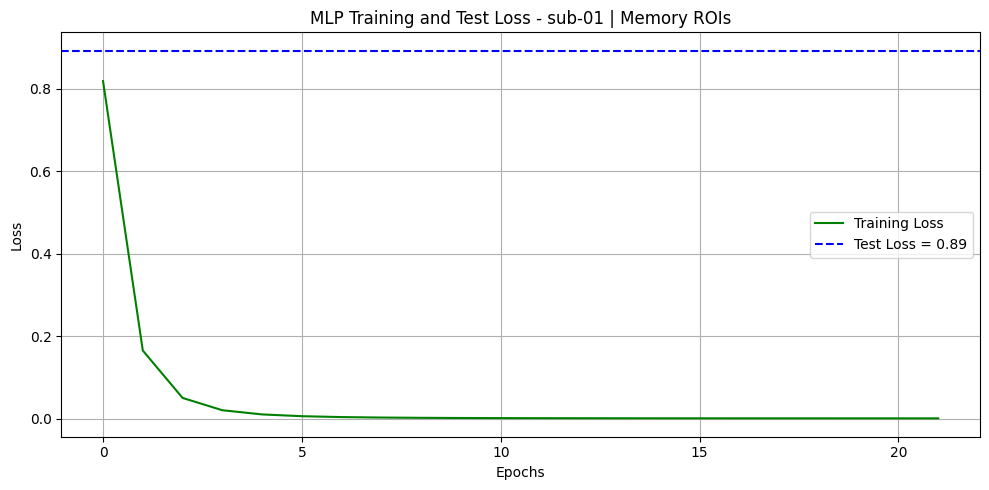



-------Running model for ROI: Visual ROIs-------


Selected 5959 voxels from ROI(s): ['Left Lateral Occipital Complex', 'Right Lateral Occipital Complex', 'Left Fusiform Face Area', 'Right Fusiform Face Area', 'Left Parahippocampal Place Area', 'Right Parahippocampal Place Area', 'Left Extrastriate Body Area', 'Right Extrastriate Body Area', 'Inferotemporal Cortex']
Filtered Data shape: (6517, 5963)
Binary label threshold (median): 0.800000011920929
Bin sizes:
 mem_bin
0.0–0.1       0
0.1–0.2       0
0.2–0.3       0
0.3–0.4       0
0.4–0.5       8
0.5–0.6      73
0.6–0.7     696
0.7–0.8    2341
0.8–0.9    2935
0.9–1.0     464
Name: count, dtype: int64

Smallest non-empty bin has 73 samples.

Balanced bin sizes:
 mem_bin
0.0–0.1     0
0.1–0.2     0
0.2–0.3     0
0.3–0.4     0
0.4–0.5     0
0.5–0.6    73
0.6–0.7    73
0.7–0.8    73
0.8–0.9    73
0.9–1.0    73
Name: count, dtype: int64

Balanced Data:


<ipython-input-3-ed5002609ad6>:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), min_bin_size), random_state=random_state))


,stimulus_name,concept,category_label,memorability_score,voxel_7884,voxel_7885,voxel_7899,voxel_7900,voxel_7901,voxel_7919,...,voxel_201414,voxel_201415,voxel_201435,voxel_201436,voxel_201437,voxel_201438,voxel_201439,voxel_201440,memorability_class,mem_bin
0,ant_10s.jpg,ant,animal,0.595238,-0.023692,0.052333,-0.076508,0.059734,0.125486,-0.074687,...,0.140819,0.065942,0.021600,0.007586,0.031072,0.084446,0.137337,0.042806,0,0.5–0.6
1,tomato_10n.jpg,tomato,food,0.564103,0.106556,0.076395,0.016348,0.052508,-0.061072,0.004757,...,-0.057592,-0.056563,-0.109865,0.031776,-0.001537,0.033739,0.021725,-0.103524,0,0.5–0.6
2,cheese_01b.jpg,cheese,dessert,0.575000,0.008522,0.006600,-0.073106,0.009192,-0.001565,0.072535,...,0.146051,0.032455,0.092571,0.012690,0.011296,-0.001198,0.004710,-0.010086,0,0.5–0.6
3,airbag_07s.jpg,airbag,part of car,0.578947,0.019850,-0.007978,0.041041,-0.000063,-0.014545,0.065568,...,-0.014352,-0.027626,0.044395,0.098306,-0.059624,0.044564,0.072951,-0.018868,0,0.5–0.6
4,defibrillator_01b.jpg,defibrillator,electronic device,0.550000,-0.107312,0.031822,0.009438,0.049471,0.058328,-0.024760,...,0.085780,0.012625,0.039919,-0.032627,0.075859,0.037538,0.071315,0.047277,0,0.5–0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,banana_04s.jpg,banana,food,0.925000,-0.052058,-0.186623,-0.011647,-0.018045,-0.053188,-0.030342,...,0.010169,-0.006190,-0.046514,-0.079524,-0.005915,-0.026257,0.003187,-0.027832,1,0.9–1.0
361,overalls_05s.jpg,overalls,clothing,0.904762,-0.069304,-0.054498,-0.080056,-0.051320,0.027491,-0.078097,...,-0.073988,-0.018079,0.026245,-0.068235,-0.074942,-0.054793,0.003954,-0.098861,1,0.9–1.0
362,peach_11n.jpg,peach,food,0.906977,-0.042100,-0.132166,-0.075051,-0.090127,-0.154524,-0.147800,...,0.059918,0.065309,-0.091618,-0.041747,0.081326,0.085578,-0.038679,0.079781,1,0.9–1.0
363,brownie_06s.jpg,brownie,dessert,0.921053,0.035970,-0.033357,0.059821,-0.003200,-0.020600,-0.022280,...,-0.040850,-0.039581,-0.027387,0.013969,0.015930,0.055181,0.062089,0.094094,1,0.9–1.0


Original Class Distribution in Train Set: [182 110]
Balanced Class Distribution in Train Set: [110 110]
Training set bin distribution:
mem_bin
0.0–0.1     0
0.1–0.2     0
0.2–0.3     0
0.3–0.4     0
0.4–0.5     0
0.5–0.6    55
0.6–0.7    57
0.7–0.8    64
0.8–0.9    61
0.9–1.0    55
Name: count, dtype: int64
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best SVC parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

SVC Evaluation Results:
Accuracy Score: 0.59
Precision Score: 0.5
F1 Score: 0.21
ROC AUC: 0.52
Predicted Class Distribution: [65, 8]


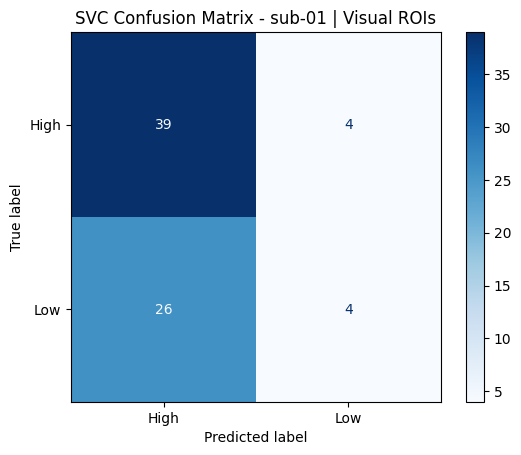

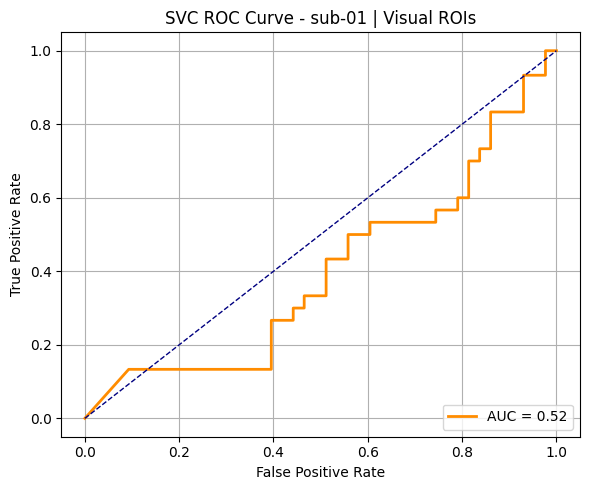


MLP Evaluation Results:
Train Accuracy Score: 0.96
(Test) Accuracy Score: 0.59
Precision Score: 0.5
F1 Score: 0.55
Predicted Class Distribution: [37, 36]


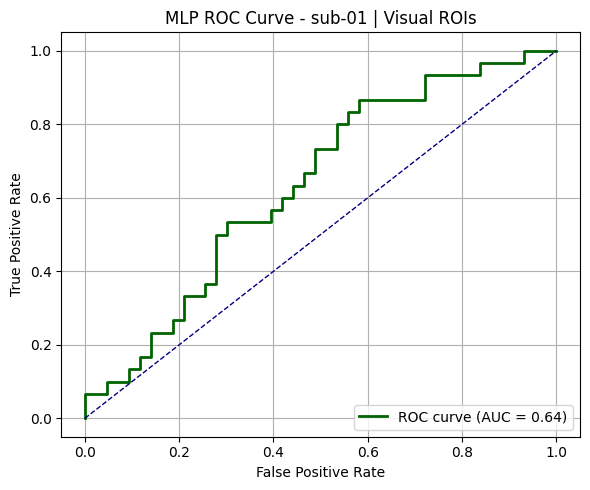

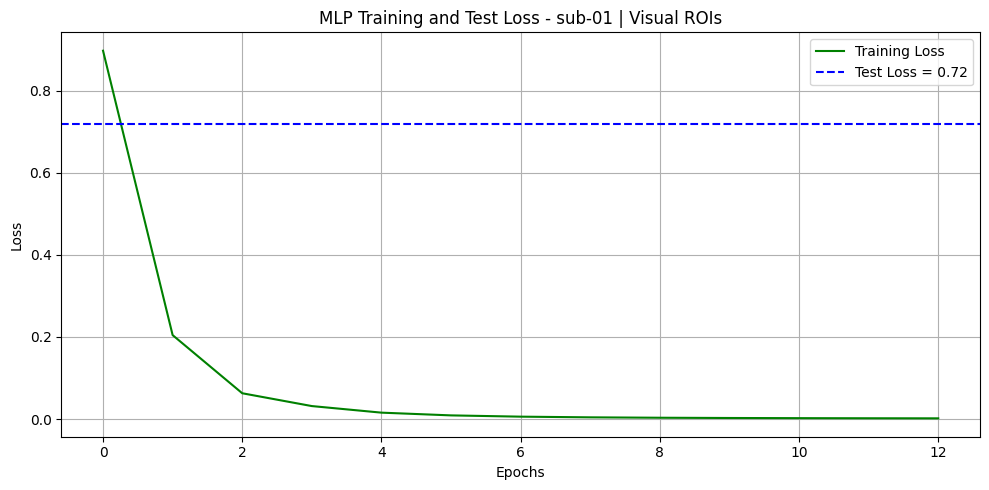



-------Running model for ROI: Right FFA-------


Selected 399 voxels from ROI(s): ['Right Fusiform Face Area']
Filtered Data shape: (6517, 403)
Binary label threshold (median): 0.800000011920929
Bin sizes:
 mem_bin
0.0–0.1       0
0.1–0.2       0
0.2–0.3       0
0.3–0.4       0
0.4–0.5       8
0.5–0.6      73
0.6–0.7     696
0.7–0.8    2341
0.8–0.9    2935
0.9–1.0     464
Name: count, dtype: int64

Smallest non-empty bin has 73 samples.

Balanced bin sizes:
 mem_bin
0.0–0.1     0
0.1–0.2     0
0.2–0.3     0
0.3–0.4     0
0.4–0.5     0
0.5–0.6    73
0.6–0.7    73
0.7–0.8    73
0.8–0.9    73
0.9–1.0    73
Name: count, dtype: int64

Balanced Data:


<ipython-input-3-ed5002609ad6>:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), min_bin_size), random_state=random_state))


,stimulus_name,concept,category_label,memorability_score,voxel_164843,voxel_164844,voxel_168436,voxel_168491,voxel_168492,voxel_168493,...,voxel_194681,voxel_194682,voxel_194731,voxel_194732,voxel_194733,voxel_194784,voxel_194785,voxel_194786,memorability_class,mem_bin
0,ant_10s.jpg,ant,animal,0.595238,-0.037792,0.118199,0.084982,-0.064291,-0.041732,0.041284,...,0.191682,0.043100,0.045584,0.025666,-0.031770,-0.021014,-0.007821,-0.051830,0,0.5–0.6
1,tomato_10n.jpg,tomato,food,0.564103,0.007406,-0.008133,-0.021791,-0.017484,0.094562,0.060255,...,-0.084273,-0.067226,-0.058121,-0.036079,-0.074631,-0.017416,0.017555,0.092051,0,0.5–0.6
2,cheese_01b.jpg,cheese,dessert,0.575000,0.164136,0.041885,0.016701,0.129380,0.092707,0.084026,...,-0.012701,0.039964,-0.044431,-0.020938,-0.022805,0.021976,-0.025124,0.023000,0,0.5–0.6
3,airbag_07s.jpg,airbag,part of car,0.578947,-0.045528,0.031936,0.090144,-0.048401,0.037264,0.021921,...,0.070122,-0.010373,0.072436,0.037828,-0.064702,-0.083119,0.016797,0.015385,0,0.5–0.6
4,defibrillator_01b.jpg,defibrillator,electronic device,0.550000,0.048876,-0.002913,-0.047195,0.007848,0.072265,-0.013641,...,-0.030561,0.043343,0.010111,-0.050209,-0.079229,0.062842,0.094353,-0.032600,0,0.5–0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,banana_04s.jpg,banana,food,0.925000,-0.077990,0.004088,0.063771,-0.040618,-0.019515,0.029666,...,-0.070644,-0.050971,0.029226,-0.006500,-0.027516,0.009211,0.023204,-0.030915,1,0.9–1.0
361,overalls_05s.jpg,overalls,clothing,0.904762,-0.020683,0.026298,-0.040560,0.079327,0.040669,-0.062243,...,-0.013743,-0.062010,0.032809,-0.096973,-0.091237,-0.075238,-0.036665,-0.129707,1,0.9–1.0
362,peach_11n.jpg,peach,food,0.906977,0.104638,0.061035,0.016440,-0.072703,0.076909,0.045789,...,-0.018093,-0.014936,-0.016871,-0.027931,0.044433,0.086072,-0.022434,-0.025677,1,0.9–1.0
363,brownie_06s.jpg,brownie,dessert,0.921053,0.000538,0.019438,-0.023886,-0.002097,-0.022011,0.090852,...,0.004525,0.012616,-0.130760,0.099005,0.121730,0.030109,0.072133,0.030910,1,0.9–1.0


Original Class Distribution in Train Set: [182 110]
Balanced Class Distribution in Train Set: [110 110]
Training set bin distribution:
mem_bin
0.0–0.1     0
0.1–0.2     0
0.2–0.3     0
0.3–0.4     0
0.4–0.5     0
0.5–0.6    55
0.6–0.7    57
0.7–0.8    64
0.8–0.9    61
0.9–1.0    55
Name: count, dtype: int64
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best SVC parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

SVC Evaluation Results:
Accuracy Score: 0.41
Precision Score: 0.41
F1 Score: 0.57
ROC AUC: 0.49
Predicted Class Distribution: [2, 71]


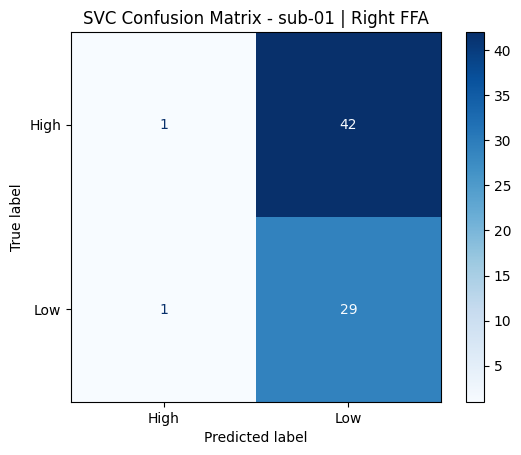

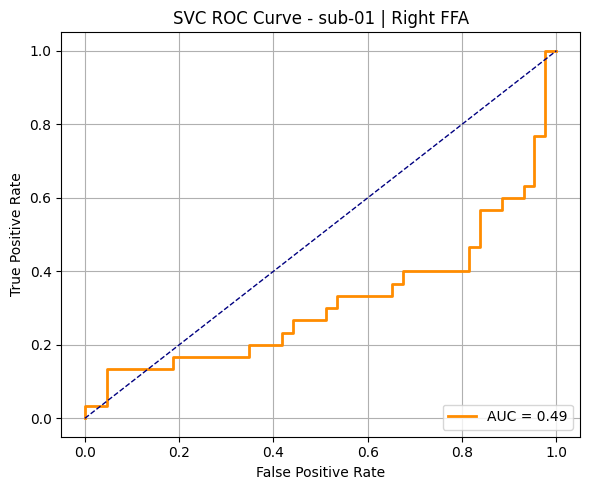


MLP Evaluation Results:
Train Accuracy Score: 0.97
(Test) Accuracy Score: 0.52
Precision Score: 0.43
F1 Score: 0.46
Predicted Class Distribution: [38, 35]


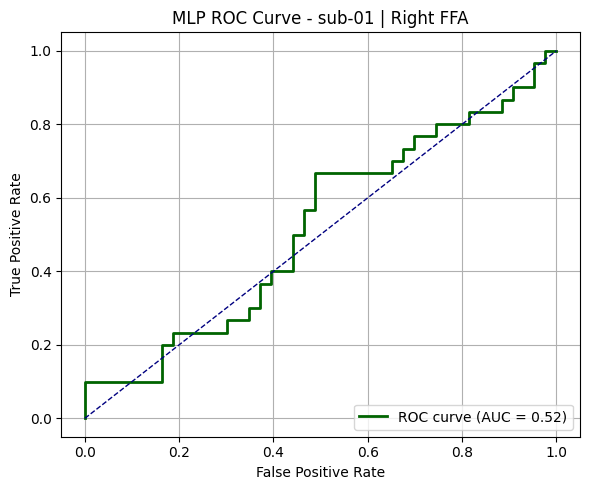

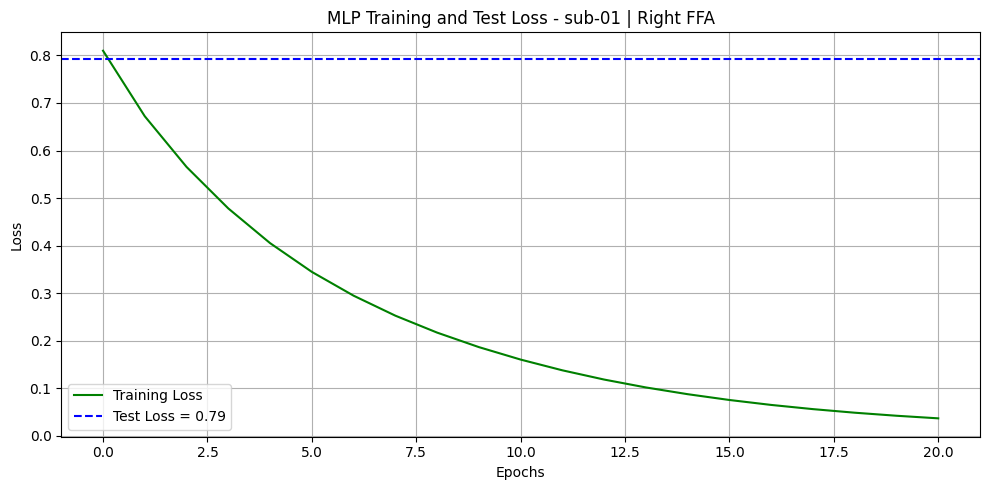



-------Running model for ROI: Left PPA-------


Selected 395 voxels from ROI(s): ['Left Parahippocampal Place Area']
Filtered Data shape: (6517, 399)
Binary label threshold (median): 0.800000011920929
Bin sizes:
 mem_bin
0.0–0.1       0
0.1–0.2       0
0.2–0.3       0
0.3–0.4       0
0.4–0.5       8
0.5–0.6      73
0.6–0.7     696
0.7–0.8    2341
0.8–0.9    2935
0.9–1.0     464
Name: count, dtype: int64

Smallest non-empty bin has 73 samples.

Balanced bin sizes:
 mem_bin
0.0–0.1     0
0.1–0.2     0
0.2–0.3     0
0.3–0.4     0
0.4–0.5     0
0.5–0.6    73
0.6–0.7    73
0.7–0.8    73
0.8–0.9    73
0.9–1.0    73
Name: count, dtype: int64

Balanced Data:


<ipython-input-3-ed5002609ad6>:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), min_bin_size), random_state=random_state))


,stimulus_name,concept,category_label,memorability_score,voxel_45500,voxel_45556,voxel_45557,voxel_45613,voxel_45614,voxel_49009,...,voxel_86403,voxel_86404,voxel_86405,voxel_86463,voxel_86464,voxel_86465,voxel_90571,voxel_90632,memorability_class,mem_bin
0,ant_10s.jpg,ant,animal,0.595238,-0.052054,0.039693,0.070041,-0.031069,-0.022798,-0.054565,...,0.064215,0.049103,-0.014147,0.092131,0.112302,-0.074077,-0.008237,0.049202,0,0.5–0.6
1,tomato_10n.jpg,tomato,food,0.564103,-0.070097,0.027615,-0.004781,-0.052134,0.044651,-0.012623,...,0.006030,-0.030013,0.040768,0.030670,0.044640,-0.044649,-0.043700,-0.023434,0,0.5–0.6
2,cheese_01b.jpg,cheese,dessert,0.575000,-0.085903,0.020861,0.023056,-0.056381,0.081507,0.117447,...,0.152569,0.001807,-0.013491,0.056600,0.096771,-0.126920,-0.035368,0.028057,0,0.5–0.6
3,airbag_07s.jpg,airbag,part of car,0.578947,-0.011208,0.024594,0.001656,0.031397,-0.081168,0.028984,...,0.153225,-0.030776,0.031148,0.052100,0.035582,-0.079727,-0.000728,-0.000609,0,0.5–0.6
4,defibrillator_01b.jpg,defibrillator,electronic device,0.550000,-0.034319,0.021751,0.030779,-0.026318,0.050101,-0.087051,...,-0.002168,0.070999,0.054937,-0.058495,0.084634,0.024299,0.020503,-0.002527,0,0.5–0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,banana_04s.jpg,banana,food,0.925000,-0.036948,-0.072727,-0.051364,0.033537,0.069489,-0.066797,...,-0.016319,-0.046260,-0.062756,0.032583,0.023064,-0.025094,0.021025,0.086390,1,0.9–1.0
361,overalls_05s.jpg,overalls,clothing,0.904762,-0.056807,0.055459,-0.015721,0.017084,-0.042583,0.099904,...,-0.063025,-0.004405,0.141056,-0.097424,-0.127505,-0.005967,0.041537,-0.046935,1,0.9–1.0
362,peach_11n.jpg,peach,food,0.906977,0.037620,-0.036158,0.047449,0.042067,0.064800,-0.007124,...,-0.127601,0.071893,0.014246,-0.120199,-0.069245,-0.094978,-0.003130,0.077808,1,0.9–1.0
363,brownie_06s.jpg,brownie,dessert,0.921053,-0.008857,0.099973,0.025211,0.057590,-0.093258,0.088854,...,0.005835,0.021026,-0.015039,0.021382,-0.040635,-0.033540,-0.006441,0.018894,1,0.9–1.0


Original Class Distribution in Train Set: [182 110]
Balanced Class Distribution in Train Set: [110 110]
Training set bin distribution:
mem_bin
0.0–0.1     0
0.1–0.2     0
0.2–0.3     0
0.3–0.4     0
0.4–0.5     0
0.5–0.6    55
0.6–0.7    57
0.7–0.8    64
0.8–0.9    61
0.9–1.0    55
Name: count, dtype: int64
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best SVC parameters: {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}

SVC Evaluation Results:
Accuracy Score: 0.62
Precision Score: 1.0
F1 Score: 0.12
ROC AUC: 0.53
Predicted Class Distribution: [71, 2]


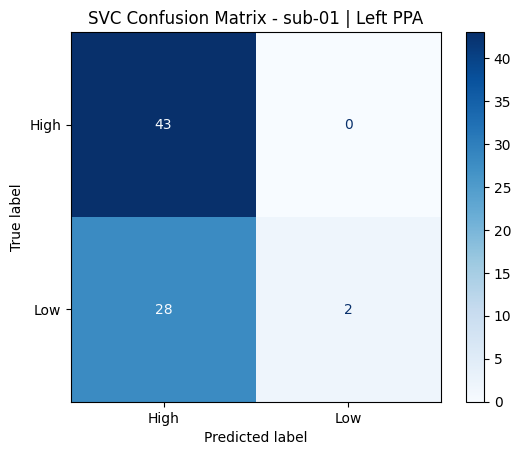

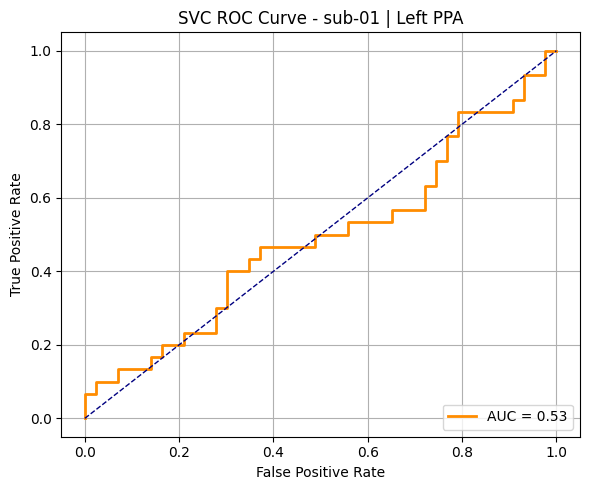


MLP Evaluation Results:
Train Accuracy Score: 0.93
(Test) Accuracy Score: 0.51
Precision Score: 0.43
F1 Score: 0.5
Predicted Class Distribution: [31, 42]


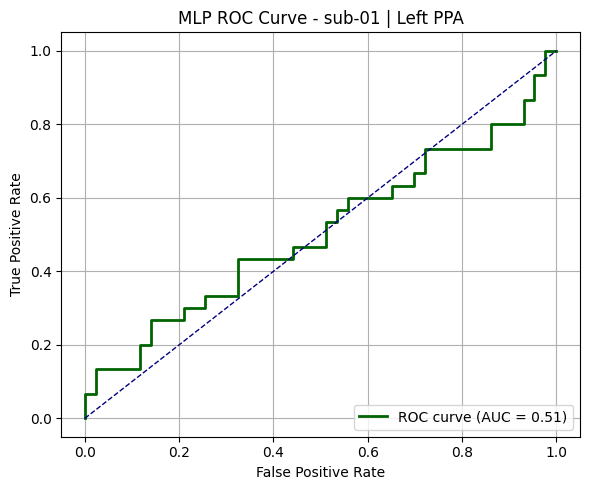

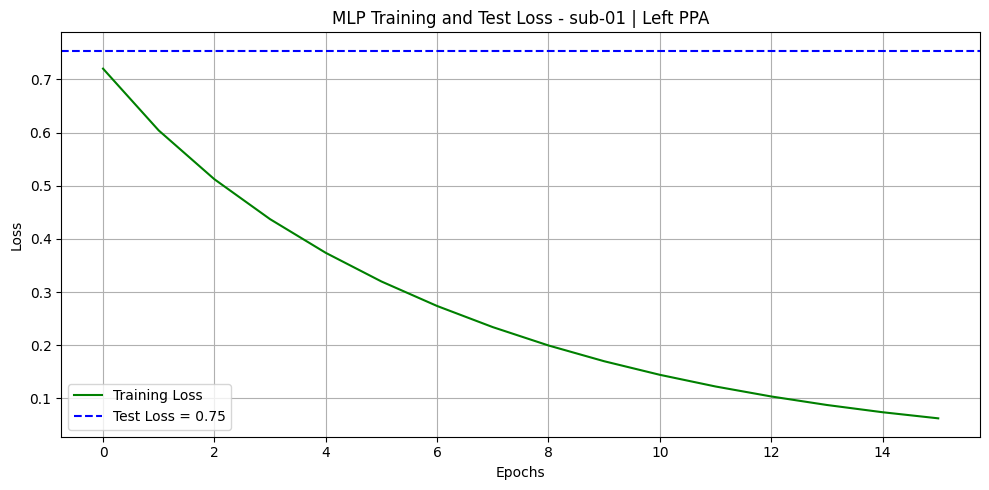

In [7]:
results = []

data, roi_df = load_data(SUBJECT_ID)

for roi_label, selected_rois in ROI_GROUPS.items():
    print(f"\n\n-------Running model for ROI: {roi_label}-------\n\n")
    prepared_data = prepare_data(data, roi_df, selected_rois, balance_method=BALANCE_METHOD)
    X = prepared_data[[col for col in prepared_data.columns if col.startswith("voxel_")]]
    y = prepared_data["memorability_class"]

    # 1. Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Original Class Distribution in Train Set:", np.bincount(y_train))

    # 2. Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 3. Balance the training set using undersampling (better to do manually)
    rus = RandomUnderSampler(random_state=42)
    X_train_balanced, y_train_balanced = rus.fit_resample(X_train_scaled, y_train)
    print("Balanced Class Distribution in Train Set:", np.bincount(y_train_balanced))
    if BALANCE_METHOD == 'bin':
      print("Training set bin distribution:")
      print(prepared_data.iloc[X_train.index]['mem_bin'].value_counts().sort_index())

    # 4. Run models
    svc_results  = run_svc(X_train_balanced, y_train_balanced, X_test_scaled, y_test, SUBJECT_ID, roi_label, method=BALANCE_METHOD)
    mlp_results = run_mlp(X_train_balanced, y_train_balanced, X_test_scaled, y_test, SUBJECT_ID, roi_label)
    results.append({
        "ROI": roi_label,
        "Model": "SVC",
        "Accuracy": svc_results['accuracy'],
        "Precision": svc_results['precision'],
        "F1": svc_results['f1_score'],
        "ROC_AUC": svc_results['roc_auc']
    })

    results.append({
        "ROI": roi_label,
        "Model": "MLP",
        "Accuracy": mlp_results['accuracy'],
        "Precision": mlp_results['precision'],
        "F1": mlp_results['f1_score'],
        "ROC_AUC": mlp_results['roc_auc']
    })

## 6) Compare models performance: MLP vs. SVC

,0,1,2,3,4,5,6,7
ROI,Memory ROIs,Memory ROIs,Visual ROIs,Visual ROIs,Right FFA,Right FFA,Left PPA,Left PPA
Model,SVC,MLP,SVC,MLP,SVC,MLP,SVC,MLP
Accuracy,0.479,0.644,0.589,0.589,0.411,0.521,0.616,0.507
Precision,0.433,0.556,0.5,0.5,0.408,0.429,1.0,0.429
F1,0.578,0.606,0.211,0.545,0.574,0.462,0.125,0.5
ROC_AUC,0.538,0.647,0.52,0.636,0.495,0.519,0.533,0.507


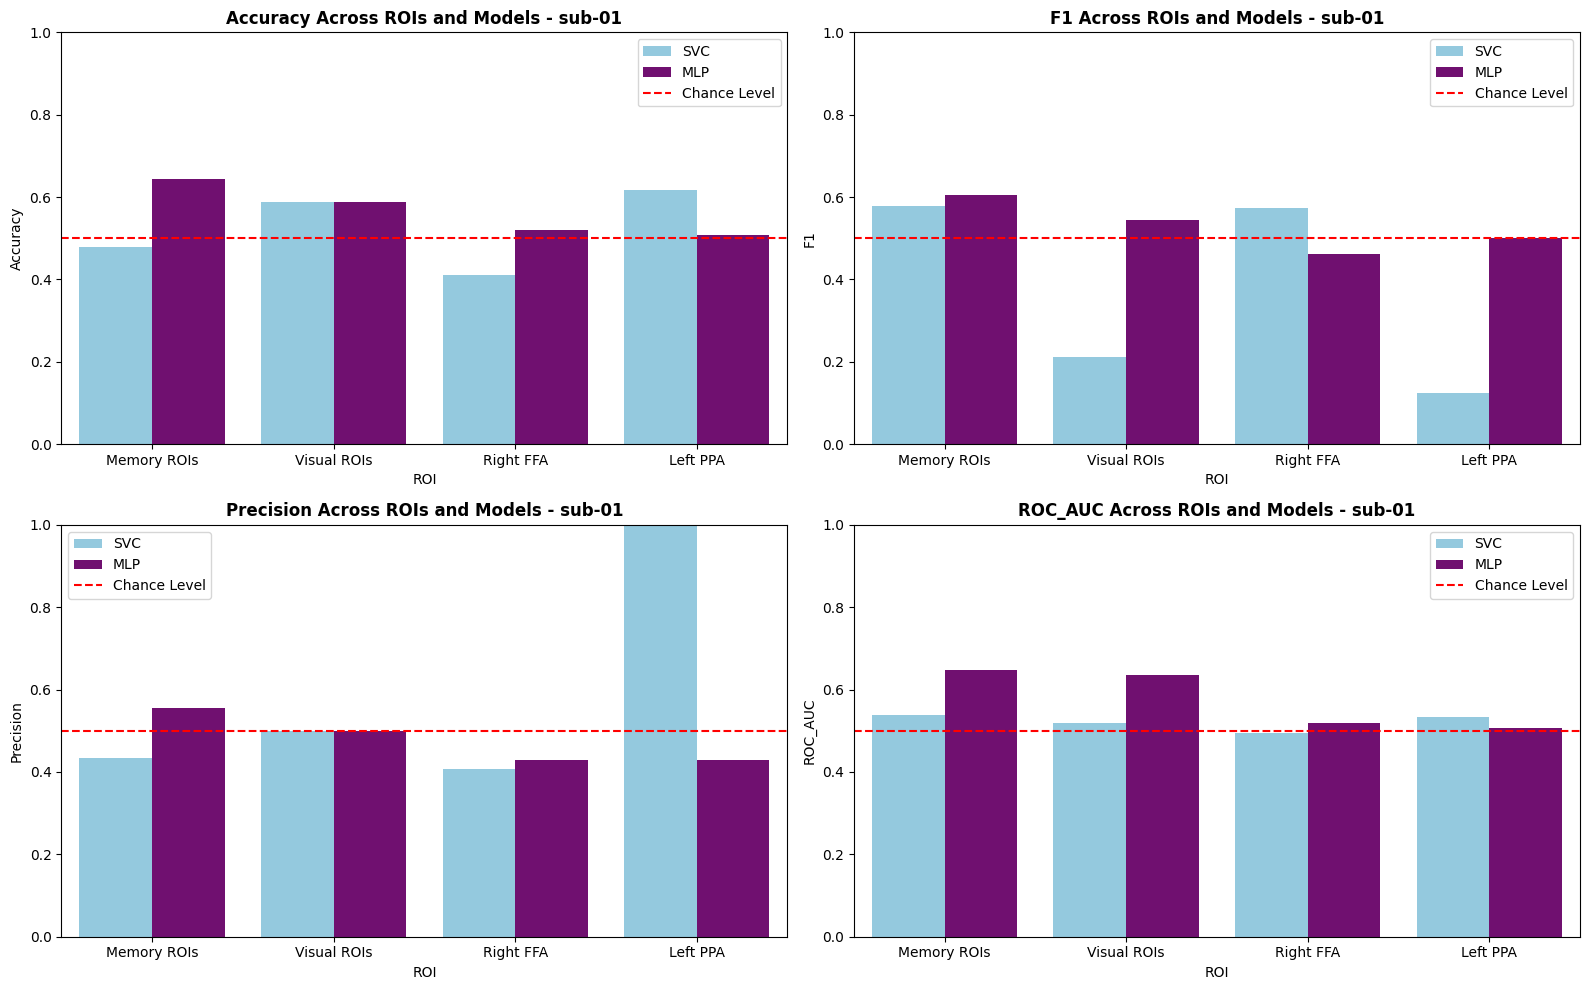

In [11]:
import seaborn as sns

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.round(3)
transposed_df = results_df.T
display(transposed_df)

# Plot each metric
metrics = ["Accuracy", "F1", "Precision", "ROC_AUC"]
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()  # Flatten to index easily

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(data=results_df, x="ROI", y=metric, hue="Model", ax=ax,
                palette={"SVC": "skyblue", "MLP": "purple"})
    ax.axhline(0.5, color="red", linestyle="--", label="Chance Level")
    ax.set_title(f"{metric} Across ROIs and Models - {SUBJECT_ID}", weight='bold')
    ax.set_ylim(0, 1)
    ax.set_xlabel("ROI")
    ax.set_ylabel(metric)
    ax.legend()

plt.tight_layout()
plt.savefig(f"model_performance_results_{SUBJECT_ID}.png", dpi=300)
plt.show()